<a href="https://colab.research.google.com/github/hzoscar/ds_challenge_1/blob/main/challengeds_1_trading_robot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robot Trading

Este es el **primer proyecto del bootcamp en data science** de Alura Latam.

En este proyecto se pide contruir un Robot Trading en Python capaz de tomar decisiones de compra y venta de Bitcoin en tiempo real. La decisión final es tomada a partir de 4 indicadores.  Para la elaboración del mismo usé Google Colaboratory. El proyecto esta dividido en 6 partes:

**1.** **Configuración del ambiente:** Instalación e importación de las librerias que seran usadas.

**2.** **Obtención de datos:**  a traves de una API se obtienen los datos históricos de precios de Bitcoin en formato JSON. El periodo a considerar son los últimos 7 días con intervalos de 5 minutos. Por otro lado, para la elaboración de uno de los indicadores se realiza Web Scraping en un site de noticias para obtener el precio actual y algunos indicadores de tendencias del Bitcoin. Una vez que se tienen los datos históricos se cargan en un DataFrame de Pandas para poder ser manipulados y analizados. Adicionalmente, se crean dos columnas SMA20 Y SMA100 (medias moviles) que seran usadas para la elaboracion de uno de los indicadores.

**3.** **Limpieza de datos:** Se identifican y eliminan los outliers, además de tratar cualquier valor nulo o duplicados en la base con el fin de calcular el precio promedio del Bitcoin.

**4.** **Tomar decisiones:** El algoritmo de decisión se basa en 4 indicadores.

  ***Indicador-1:*** Con el precio promedio hallado en el paso anterior, se compara con el precio actual y tendencia del Bitcoin, que previamente fue obtenido con Web Scraping. Si el precio actual es mayor/igual que la media y la tendencia es de baja, entonces se debe vender, pero si el precio actual es menor que la media y la tendencia es de alta, entonces se debe comprar.

  ***Indicador-2:*** Las medias moviles creadas en el primer paso se usan de la siguiente manera:  Las señales de compra se producen cuando la SMA a corto plazo (SMA20) cruza por encima de la SMA a largo plazo (SMA100), lo que indica una posible tendencia alcista. Por el contrario, las señales de venta se producen cuando la SMA20 cruza por debajo de la SMA100, lo que sugiere una posible tendencia bajista.

  ***Indicador-3:*** Este indicador se basa en las bandas de Bollinger. Se compra, vende o se espera en función de la posición actual del precio con respecto a las Bandas de Bollinger las cuales son creadas con la libreria TALIB.

  ***Indicador-4:*** Este indicador calcula el RSI y determina si comprar, vender o esperar en función de los valores del RSI y de los niveles de sobrecompra(70) y sobreventa(30) especificados.

**5.** **Visualización:** Se utilizan las librería Matplotlib y chartstudio para crear un candlestick chart de las últimas 100 observaciones junto a los gráficos de cada indicador. Por último, se muestra un mensaje en el gráfico que indique “Vender”, “Comprar” o “” según sea la decisión del algoritmo.

**6.** **Automatización:** Finalmente, ahora que se tiene el algoritmo de decisión, se automatizar el proceso. se utiliza la librería de Python "time" para ejecutar el algoritmo de decisión cada 5 minutos y actualizar el gráfico.

# 1. setting up the environment (Configuracion del ambiente)

#### 1.1 Global variables

En este primer paso se definen todas las variables y se instalan y/o importan todas las librerias que se van a utilizar a lo largo del código.

(In this first step all variables are defined and all libraries to be used throughout the code are installed and/or imported.)

In [ ]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, algoritmo_decision_msa, algoritmo_decision_bands, algoritmo_decision_rsi, decision_final

#### 1.2 Libraries

In [ ]:
# Biblioteca para hacer el diagrama de velas candlestick (library to create the candlestick chart)
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 455.6 kB/s eta 0:00:00


In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
#Biblioteca para crear indicadores adicionales (Library to create additional indicators )
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

     ━━━━━━━━

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
import random
import requests
import time
from IPython.display import clear_output
from chart_studio import plotly
import plotly.graph_objs as go
from chart_studio import grid_objs
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)
import pytz

# 2. Data collection

### 2.1 Getting historical market data

In [ ]:
"""
def importar_base_bitcoin():
  global df_bitcoin
  btc = yf.Ticker('BTC-USD')
  hist = btc.history(period='7d',interval='5m')
  df_bitcoin = (hist.sort_index(ascending=False))
  return df_bitcoin
"""


"\ndef importar_base_bitcoin():\n  global df_bitcoin\n  btc = yf.Ticker('BTC-USD')\n  hist = btc.history(period='7d',interval='5m')\n  df_bitcoin = (hist.sort_index(ascending=False))\n  return df_bitcoin\n"

In [ ]:
# Se obtienen los datos a través de la siguiente función.
def importar_base_bitcoin(data,period,interval):
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, algoritmo_decision_msa, algoritmo_decision_bands, algoritmo_decision_rsi, decision_final
  btc = yf.Ticker(data) # la API que se utiliza para obtener los datos es yfinance
  df_bitcoin = btc.history(period=period,interval=interval)
  mine_tz = pytz.timezone('Europe/Paris') # utilizo una de las funciones de la libreria pytz para cambiar la zona del tiempo del dataset creado.
  # Dado que estoy en Italia uso la timezone que me ofrece la librería.
  df_bitcoin.index = df_bitcoin.index.tz_convert(mine_tz)
  df_bitcoin['SMA20'] = df_bitcoin['Close'].rolling(window=20).mean() #creo una columna para la primera media movil de 20 periodos
  df_bitcoin['SMA100'] = df_bitcoin['Close'].rolling(window=100).mean() #creo una columna para la segunda media movil de 100 periodos
  df_bitcoin.sort_index(ascending=False, inplace=True) # Los organizo desde la observación más reciente
  return(df_bitcoin)

In [ ]:
importar_base_bitcoin('BTC-USD','7d','5m')

Open          High           Low  \
Datetime                                                              
2023-11-01 22:35:00+01:00  35296.148438  35341.515625  35284.285156   
2023-11-01 22:30:00+01:00  35350.406250  35350.406250  35302.824219   
2023-11-01 22:25:00+01:00  35337.890625  35351.648438  35284.269531   
2023-11-01 22:20:00+01:00  35369.101562  35389.566406  35322.093750   
2023-11-01 22:15:00+01:00  35323.398438  35411.652344  35323.398438   
...                                 ...           ...           ...   
2023-10-26 02:20:00+02:00  34548.535156  34554.820312  34537.343750   
2023-10-26 02:15:00+02:00  34533.218750  34543.382812  34524.519531   
2023-10-26 02:10:00+02:00  34496.804688  34527.507812  34484.953125   
2023-10-26 02:05:00+02:00  34521.175781  34521.175781  34474.617188   
2023-10-26 02:00:00+02:00  34504.289062  34509.437500  34474.312500   

                                  Close     Volume  Dividends  Stock Splits  \
Datetime                                                                      
2023-11-01 22:35:00+01:00  35341.515625   17489920        0.0           0.0   
2023-11-01 22:30:00+01:00  35309.125000   38596608        0.0           0.0   
2023-11-01 22:25:00+01:00  35351.648438   52721664        0.0           0.0   
2023-11-01 22:20:00+01:00  35348.906250   66127872        0.0           0.0   
2023-11-01 22:15:00+01:00  35387.015625  237277184        0.0           0.0   
...                                 ...        ...        ...           ...   
2023-10-26 02:20:00+02:00  34554.820312          0        0.0           0.0   
2023-10-26 02:15:00+02:00  34543.382812          0        0.0           0.0   
2023-10-26 02:10:00+02:00  34527.507812     317440        0.0           0.0   
2023-10-26 02:05:00+02:00  34505.679688          0        0.0           0.0   
2023-10-26 02:00:00+02:00  34509.437500          0        0.0           0.0   

                                  SMA20        SMA100  
Datetime                                               
2023-11-01 22:35:00+01:00  35051.817773  34604.198164  
2023-11-01 22:30:00+01:00  35012.514844  34600.099375  
2023-11-01 22:25:00+01:00  34973.065430  34594.907031  
2023-11-01 22:20:00+01:00  34935.609766  34589.253164  
2023-11-01 22:15:00+01:00  34898.524805  34584.283281  
...                                 ...           ...  
2023-10-26 02:20:00+02:00           NaN           NaN  
2023-10-26 02:15:00+02:00           NaN           NaN  
2023-10-26 02:10:00+02:00           NaN           NaN  
2023-10-26 02:05:00+02:00           NaN           NaN  
2023-10-26 02:00:00+02:00           NaN           NaN  

[1984 rows x 9 columns]

In [ ]:
len(df_bitcoin)

1984

### 2.2 Getting the coinmarketcap indicators

In [ ]:
# Funcion para obtener de esta página web https://coinmarketcap.com/ el precio actual y la tendencia del Bitcoin
# usando web scraping beautifulsoup
def extraer_tendencias():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, algoritmo_decision_msa, algoritmo_decision_bands, algoritmo_decision_rsi, decision_final
  header_list=['Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
  'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
  'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
  'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
  'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
  'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15',
  'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15'] # Lista de user_agent para ser usados.

  url = 'https://coinmarketcap.com/'
  user_agent = random.choice(header_list)
  headers = {'User-Agent':user_agent}
  page = requests.get(url,headers=headers)
  soup = BeautifulSoup(page.text,features='lxml') # El código de toda la página web
  helper = soup.find('table',{'class':'sc-66133f36-3 etbEmy cmc-table'}) # Extrayendo el código de la tabla en la cual se encuentran los datos requeridos
  boxes = helper.find_all('div',{'class':['sc-a0353bbc-0 gDrtaY','sc-a0353bbc-0 gDrtaY rise','sc-a0353bbc-0 gDrtaY fall']}) #extracción del precio actual de cada fila
  precio_actual = float( boxes[0].text.replace('$', '').replace(',', '')) # Obteniendo el precio de la primera fila
  frechas = helper.find_all('td',{'style':'text-align:end'}) #Extracción del objeto que me sirve para identificar la tendencia de cada fila
  if frechas[1].span['class'][1] == 'iwhBxy': # obteniendo la tendencia a través del tipo de clase que aparecía
    tendencia = 'Alta'
  else:
    tendencia = 'Baja'
  return precio_actual, tendencia


In [ ]:
extraer_tendencias()
print('El precio actual del bitcoin es de -> {}'.format(precio_actual))
print('La tendenncia actual es hacia la  -> {}'.format(tendencia))

El precio actual del bitcoin es de -> 35229.22
La tendenncia actual es hacia la  -> Baja


# 3. Data Cleaning

In [ ]:
# Se identifican y eliminan los outliers, además de tratar cualquier valor nulo o duplicados en la base con el fin de calcular el precio promedio del Bitcoin
df_bitcoin_limpio = df_bitcoin.copy()
# Se utiliza una copia del dataset original

In [ ]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1981 entries, 2023-11-01 22:00:00+01:00 to 2023-10-26 02:00:00+02:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1981 non-null   float64
 1   High          1981 non-null   float64
 2   Low           1981 non-null   float64
 3   Close         1981 non-null   float64
 4   Volume        1981 non-null   int64  
 5   Dividends     1981 non-null   float64
 6   Stock Splits  1981 non-null   float64
 7   SMA20         1962 non-null   float64
 8   SMA100        1882 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 154.8 KB


In [ ]:
df_bitcoin_limpio.describe()

Open          High           Low         Close        Volume  \
count   1981.000000   1981.000000   1981.000000   1981.000000  1.981000e+03   
mean   34292.263750  34306.616909  34278.407262  34292.832205  1.613616e+07   
std      256.315255    258.384313    255.103936    256.921518  4.625476e+07   
min    33450.968750  33473.835938  33416.886719  33454.765625  0.000000e+00   
25%    34100.113281  34107.953125  34090.976562  34099.386719  0.000000e+00   
50%    34296.394531  34313.046875  34283.597656  34299.609375  0.000000e+00   
75%    34487.218750  34498.664062  34474.257812  34488.308594  1.442816e+07   
max    35431.445312  35431.445312  35431.445312  35431.445312  7.187200e+08   

       Dividends  Stock Splits         SMA20        SMA100  
count     1981.0        1981.0   1962.000000   1882.000000  
mean         0.0           0.0  34288.436547  34274.635888  
std          0.0           0.0    245.836200    221.012936  
min          0.0           0.0  33600.458203  33773.903203  
25%          0.0           0.0  34095.859326  34091.454932  
50%          0.0           0.0  34293.440625  34333.754492  
75%          0.0           0.0  34483.036377  34462.396279  
max          0.0           0.0  34798.805273  34669.293477

<Axes: >

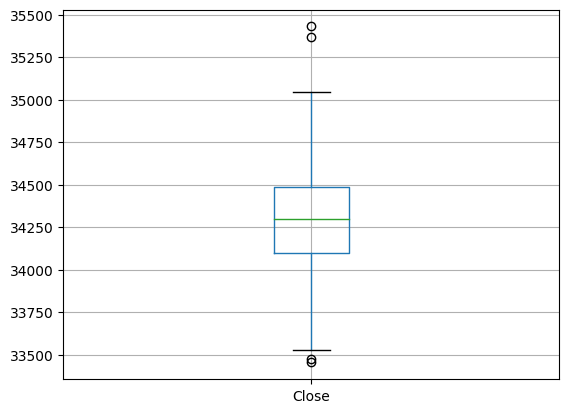

In [ ]:
df_bitcoin_limpio.boxplot('Close') # Se identifican los outliers

In [ ]:
def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, algoritmo_decision_msa, algoritmo_decision_bands, algoritmo_decision_rsi, decision_final
  df_bitcoin_limpio = df_bitcoin.copy()
  # Identificando y eliminando valores duplicados por el index
  if len(df_bitcoin_limpio) != len(df_bitcoin_limpio.index.unique()):
    df_bitcoin_limpio.index.drop_duplicates(keep = False)

# Identificando y eliminando valores nulos del dataset
  elif df_bitcoin_limpio.Close.isnull().sum() > 0:
    df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset=['Close'])

# Identificando y eliminando los registros que tienen un volumen igual a 0
  elif len(df_bitcoin_limpio[(df_bitcoin_limpio.Volume) == 0])!= 0:
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio.Volume) != 0]

  else:
    df_bitcoin_limpio

# Codigo para hallar los quantiles

  valor = df_bitcoin_limpio.Close
  Q1 = valor.quantile(.25)
  Q3 = valor.quantile(.75)
  IIQ = Q3 - Q1

# Se halla ma media partiendo de los valores que se encuentran entre el tercer y el primer quantil.
  df_bitcoin_limpio = df_bitcoin_limpio[(valor >= Q1) & (valor <= Q3)]

  media_bitcoin = df_bitcoin_limpio.Close.mean().round(2)

  return media_bitcoin, df_bitcoin_limpio

In [ ]:
limpieza_datos()


(34390.83,
                                    Open          High           Low  \
 Datetime                                                              
 2023-11-01 20:55:00+01:00  34532.777344  34570.308594  34532.777344   
 2023-11-01 20:50:00+01:00  34591.585938  34591.585938  34520.136719   
 2023-11-01 20:15:00+01:00  34542.996094  34564.394531  34535.921875   
 2023-11-01 19:45:00+01:00  34533.695312  34555.488281  34498.652344   
 2023-11-01 19:40:00+01:00  34599.226562  34599.226562  34508.132812   
 ...                                 ...           ...           ...   
 2023-10-26 08:15:00+02:00  34488.996094  34501.230469  34488.996094   
 2023-10-26 08:10:00+02:00  34488.558594  34488.558594  34458.667969   
 2023-10-26 08:05:00+02:00  34451.484375  34464.152344  34451.484375   
 2023-10-26 07:55:00+02:00  34544.324219  34544.324219  34526.164062   
 2023-10-26 02:10:00+02:00  34496.804688  34527.507812  34484.953125   
 
                                   Close    Volume 

In [ ]:
media_bitcoin

34390.83

<Axes: >

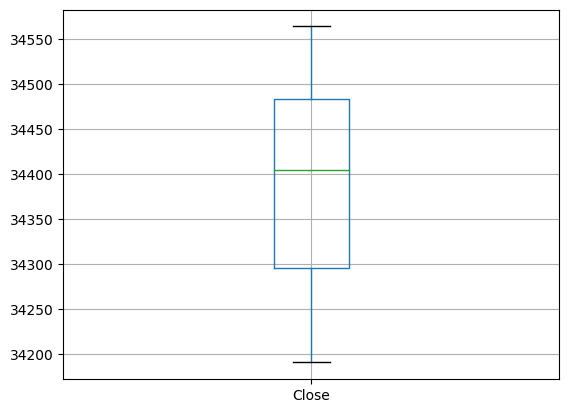

In [ ]:
limpieza_datos()[1].boxplot('Close') # Se revisa si aún existen outliers.

# 4. Trading Strategy

 El algoritmo de decisión se basa en 4 indicadores:

### 4.1 Indicador-1

In [ ]:
# Con el precio promedio hallado en el paso anterior,
# se compara con el precio actual y tendencia del Bitcoin,
# que previamente fue obtenido con Web Scraping.
# Si el precio actual es mayor/igual que la media y la tendencia es de baja,
# entonces se debe vender, pero si el precio actual es menor que la media y
# la tendencia es de alta, entonces se debe comprar.

def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, algoritmo_decision_msa, algoritmo_decision_bands, algoritmo_decision_rsi, decision_final

  buy_conditions = precio_actual < media_bitcoin and tendencia == 'Alta'
  sell_conditions= precio_actual >= media_bitcoin and tendencia == 'Baja'

  if buy_conditions:
    algoritmo_decision = 'Comprar'
  elif sell_conditions:
    algoritmo_decision = 'Vender'
  else:
    algoritmo_decision = 'Esperar'
  return algoritmo_decision

In [ ]:
tomar_decisiones()

'Esperar'

In [ ]:
algoritmo_decision

'Esperar'

### 4.2 Indicador-2

In [ ]:
# Las medias moviles creadas en el primer paso se usan de la siguiente manera:
# Las señales de compra se producen cuando la SMA a corto plazo (SMA20) cruza por
# encima de la SMA a largo plazo (SMA100), lo que indica una posible tendencia  alcista.
# Por el contrario, las señales de venta se producen cuando la SMA20 cruza por
# debajo de la SMA100, lo que sugiere una posible tendencia bajista.

def tomar_decisiones_msa():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, algoritmo_decision_msa, algoritmo_decision_bands, algoritmo_decision_rsi, decision_final

  buy_conditions =  df_bitcoin['SMA20'][-2] < df_bitcoin['SMA100'][-2] and df_bitcoin['SMA20'][-1] > df_bitcoin['SMA100'][-1]
  sell_conditions = df_bitcoin['SMA20'][-2] > df_bitcoin['SMA100'][-2] and df_bitcoin['SMA20'][-1] < df_bitcoin['SMA100'][-1]

  if buy_conditions:
    algoritmo_decision_msa = 'Comprar'
  elif sell_conditions:
    algoritmo_decision_msa = 'Vender'
  else:
    algoritmo_decision_msa = 'Esperar'

  return algoritmo_decision_msa

In [ ]:
tomar_decisiones_msa()

'Esperar'

### 4.3 Indicador-3

In [ ]:
# Este indicador se basa en las bandas de Bollinger. Se compra, vende o se espera
# en función de la posición actual del precio con respecto a las Bandas de Bollinger
# las cuales son creadas con la libreria TALIB.
def tomar_decisiones_bands():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, algoritmo_decision_msa, algoritmo_decision_bands, algoritmo_decision_rsi, decision_final
  upper_band, middle_band, lower_band = talib.BBANDS(df_bitcoin['Close'], timeperiod=20)
  ultimo_precio = df_bitcoin['Close'][-1]

  if ultimo_precio < lower_band[-1]:
        algoritmo_decision_bands = 'Comprar'
  elif ultimo_precio > upper_band[-1]:
        algoritmo_decision_bands = 'Vender'
  else:
        algoritmo_decision_bands = 'Esperar'
  return algoritmo_decision_bands

In [ ]:
tomar_decisiones_bands()

'Esperar'

In [ ]:
algoritmo_decision_bands

'Esperar'

### 4.4 Indicador-4

In [ ]:
# Este indicador calcula el RSI y determina si comprar, vender o esperar en función
# de los valores del RSI y de los niveles de sobrecompra(70) y sobreventa(30)
# especificados. Se utiliza la libreria TALIB para crear dicho indicador.
def tomar_decisiones_rsi():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, algoritmo_decision_msa, algoritmo_decision_bands, algoritmo_decision_rsi, decision_final
  sobrecompra = 70
  sobreventa= 30

  rsi = talib.RSI(df_bitcoin['Close'], timeperiod=20)

  if rsi[-1] < sobreventa:
    algoritmo_decision_rsi = 'Comprar'
  elif rsi[-1] > sobrecompra:
    algoritmo_decision_rsi = 'Vender'
  else:
    algoritmo_decision_rsi = 'Esperar'
  return algoritmo_decision_rsi

In [ ]:
tomar_decisiones_rsi()

'Esperar'

In [ ]:
algoritmo_decision_rsi

'Esperar'

In [ ]:
# La decisión final  se toma si 3 de los 4 indicadores arrojan las misma respuesta. En caso contrario, se espera.
def tomar_decision_final():
  global algoritmo_decision,  algoritmo_decision_msa, algoritmo_decision_bands, algoritmo_decision_rsi, decision_final
  indicadores=[algoritmo_decision,  algoritmo_decision_msa, algoritmo_decision_bands, algoritmo_decision_rsi]

  esperar=indicadores.count('Esperar')
  vender=indicadores.count('Vender')
  comprar=indicadores.count('Comprar')

  keys=('Esperar','Vender','Comprar')
  values=(esperar,vender,comprar)

  rta = dict(zip(keys,values))

  mayor= 0
  for value in rta.values():
    if value > mayor:
      mayor=value

  if mayor >= 3:
    obteniendo_key = [key for key, value in rta.items() if value == mayor]
    decision_final = obteniendo_key[0]
  else:
    decision_final ='Esperar'

  return decision_final

In [ ]:
tomar_decision_final()

'Esperar'

In [ ]:
decision_final

'Esperar'

#5. Visualization

In [ ]:
# Funcion auxiliar para el "candlestick" gráfico

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
# Se utilizan las librería Matplotlib y chartstudio para crear un candlestick chart
# de las últimas 100 observaciones junto a los gráficos de cada indicador.
# Por último, se muestra un mensaje en el gráfico que indique “Vender”, “Comprar” o
# “esperar” según sea la decisión del algoritmo.

def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision,  algoritmo_decision_msa, algoritmo_decision_bands, algoritmo_decision_rsi, decision_final
  area = plt.figure(figsize=(16, 9))

  # Candlestick graph
  configure_plotly_browser_state()
  init_notebook_mode(connected=True)  # Initialize Plotly for offline mode
  trace = go.Candlestick(x=df_bitcoin.index,
                      open=df_bitcoin[-100:].Open,
                      high=df_bitcoin[-100:].High,
                      low=df_bitcoin[-100:].Low,
                      close=df_bitcoin[-100:].Close)
  layout = go.Layout(
      title="<b>Gráficos de velas del precio del Bitcoin últimas 100 observaciones (intervalo 5 min)</b>",
      title_x=0.5,
      title_xanchor="center",
      xaxis=dict(title="Date"),
      yaxis=dict(title="Price")
  )

  fig = go.Figure(data=[trace], layout=layout)
  iplot(fig,filename='candlestick', show_link=False)


  g1 =area.add_subplot(4,2,1)
  g2 =area.add_subplot(4,2,2)
  g3 =area.add_subplot(4,2,3)
  g4 =area.add_subplot(4,2,4)
  g5 =area.add_subplot(4,2,5)
  g6 =area.add_subplot(4,2,6)

  # Primer gráfico

  g1.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio Bitcoin', alpha=0.7, color='lightseagreen')
  g1.axhline(y=media_bitcoin, color='red', linestyle='--', label=f'Precio medio ({media_bitcoin:.2f})')
  g1.set_title('Gráfico 1 - Precio de cierre y promedio del Bitcoin',fontweight="bold")
  g1.set_xlabel('Date')
  g1.set_ylabel('Price')
  g1.grid(True)
  g1.legend()

  # Anotaciones basadas en el primer gráfico

  g5.annotate('Indicador media', xy=(0.02, 0.85), fontsize=12,fontweight="bold")
  g5.annotate('y tendencias', xy=(0.035, 0.73), fontsize=12,fontweight="bold")
  g5.annotate('(Gráfico 1)', xy=(0.04, 0.59), fontsize=12,fontweight="bold")
  g5.annotate('Decisión: {}'.format(algoritmo_decision), xy=(0.025, 0.40), fontsize=12)
  g5.annotate('Precio act: {}'.format(precio_actual), xy=(0.01, 0.25), fontsize=12)
  g5.annotate('Tendencia: {}'.format(tendencia), xy=(0.025, 0.10), fontsize=12)


  # Segundo gráfico

  g2.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio Bitcoin', alpha=0.7, color='lightseagreen')
  g2.plot(df_bitcoin.index, df_bitcoin['SMA20'], label='SMA20', linestyle='--', color='orange')
  g2.plot(df_bitcoin.index, df_bitcoin['SMA100'], label='SMA100', linestyle='--', color='red')

  g2.set_title('Gráfico 2 - Precio de cierre del Bitcoin con SMA20 y SMA100',fontweight="bold")
  g2.set_xlabel('Date')
  g2.set_ylabel('Price')
  g2.grid(True)
  g2.legend()

  # Anotaciones basadas en el segundo gráfico

  g5.annotate('Indicador SMA20', xy=(0.28, 0.85), fontsize=12,fontweight="bold")
  g5.annotate('y SMA 100', xy=(0.315, 0.73), fontsize=12,fontweight="bold")
  g5.annotate('(Gráfico 2)', xy=(0.315, 0.59), fontsize=12,fontweight="bold")
  g5.annotate('Decisión: {}'.format(algoritmo_decision_msa), xy=(0.29, 0.35), fontsize=12)

  # Tercer gráfico
  g3.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio Bitcoin', alpha=0.7, color='lightseagreen')
  upper_band, middle_band, lower_band = talib.BBANDS(df_bitcoin['Close'], timeperiod=20)
  g3.plot(df_bitcoin.index, upper_band, label='Upper Bollinger Band', linestyle='--', color='red')
  #g3.plot(df_bitcoin.index, middle_band, label='Middle Bollinger Band', linestyle='--', color='orange')
  g3.plot(df_bitcoin.index, lower_band, label='Lower Bollinger Band', linestyle='--', color='green')

  g3.set_title('Gráfico 3 - Precio de cierre del Bitcoin con Bollinger Bands',fontweight="bold")
  g3.set_xlabel('Date')
  g3.set_ylabel('Price')
  g3.grid(True)
  g3.legend()

  # Anotaciones basadas en el tercer gráfico

  g5.annotate('Indicador', xy=(0.57, 0.85), fontsize=12,fontweight="bold")
  g5.annotate('Bollinger Bands', xy=(0.53, 0.73), fontsize=12,fontweight="bold")
  g5.annotate('(Gráfico 3)', xy=(0.56, 0.59), fontsize=12,fontweight="bold")
  g5.annotate('Decisión: {}'.format(algoritmo_decision_bands), xy=(0.53, 0.35), fontsize=12)

  # Cuarto gráfico

  rsi = talib.RSI(df_bitcoin['Close'], timeperiod=20)
  g4.plot(df_bitcoin.index, rsi, label='RSI', linestyle='--', color='purple')
  g4.axhline(70, color='red', linestyle='--', label='Overbought (70)')
  g4.axhline(30, color='green', linestyle='--', label='Oversold (30)')

  g4.set_title('Gráfico 4 - Indicador RSI',fontweight="bold")
  g4.set_xlabel('Date')
  g4.set_ylabel('RSI')
  g4.grid(True)
  g4.legend()

  # Anotaciones basadas en el cuarto gráfico

  g5.annotate('Indicador', xy=(0.8, 0.85), fontsize=12,fontweight="bold")
  g5.annotate('RSI', xy=(0.84, 0.73), fontsize=14,fontweight="bold")
  g5.annotate('(Gráfico 4)', xy=(0.79, 0.59), fontsize=12,fontweight="bold")
  g5.annotate('Decisión: {}'.format(algoritmo_decision_rsi), xy=(0.77, 0.35), fontsize=12)

  # Extra
  area.suptitle("Gráficos de análisis del precio de cierre del Bitcoin en los últimos 7 días (intervalo 5 min)", fontsize=20,fontweight="bold")

  g5.set_title('Resultado de todos los indicadores considerados',fontweight="bold")
  g5.set_xticklabels([])
  g5.set_yticklabels([])
  g5.set_xticks([])
  g5.set_yticks([])

  g6.set_title('Decisión final',fontweight="bold")
  g6.annotate('Llego el momento de:', xy=(0.35, 0.8), fontsize=12,fontweight="bold",color='black')
  g6.annotate(decision_final, xy=(0.3, 0.3), fontsize=48,fontweight="bold",color='teal')
  g6.set_xticklabels([])
  g6.set_yticklabels([])
  g6.set_xticks([])
  g6.set_yticks([])

  area.tight_layout()


  return plt.show()


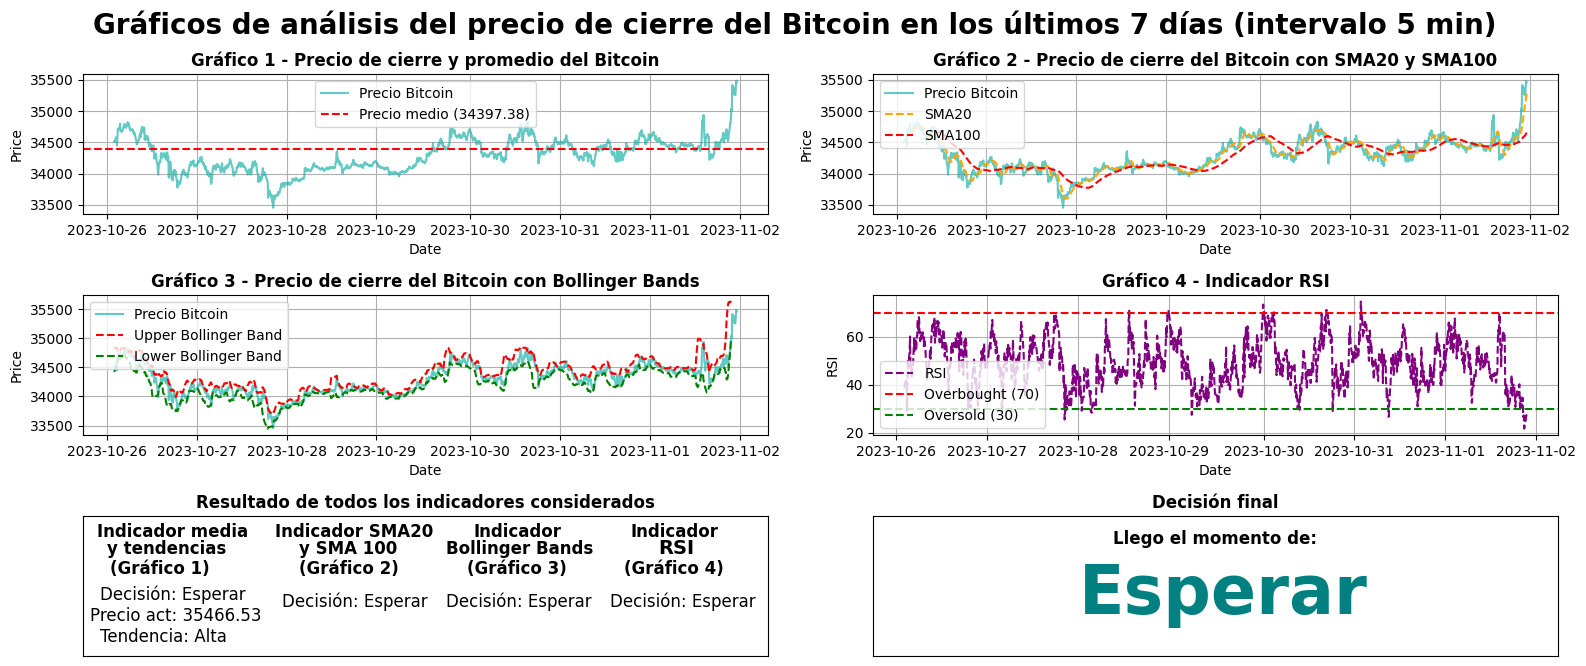

In [ ]:
visualizacion()

#6. Automatizacion

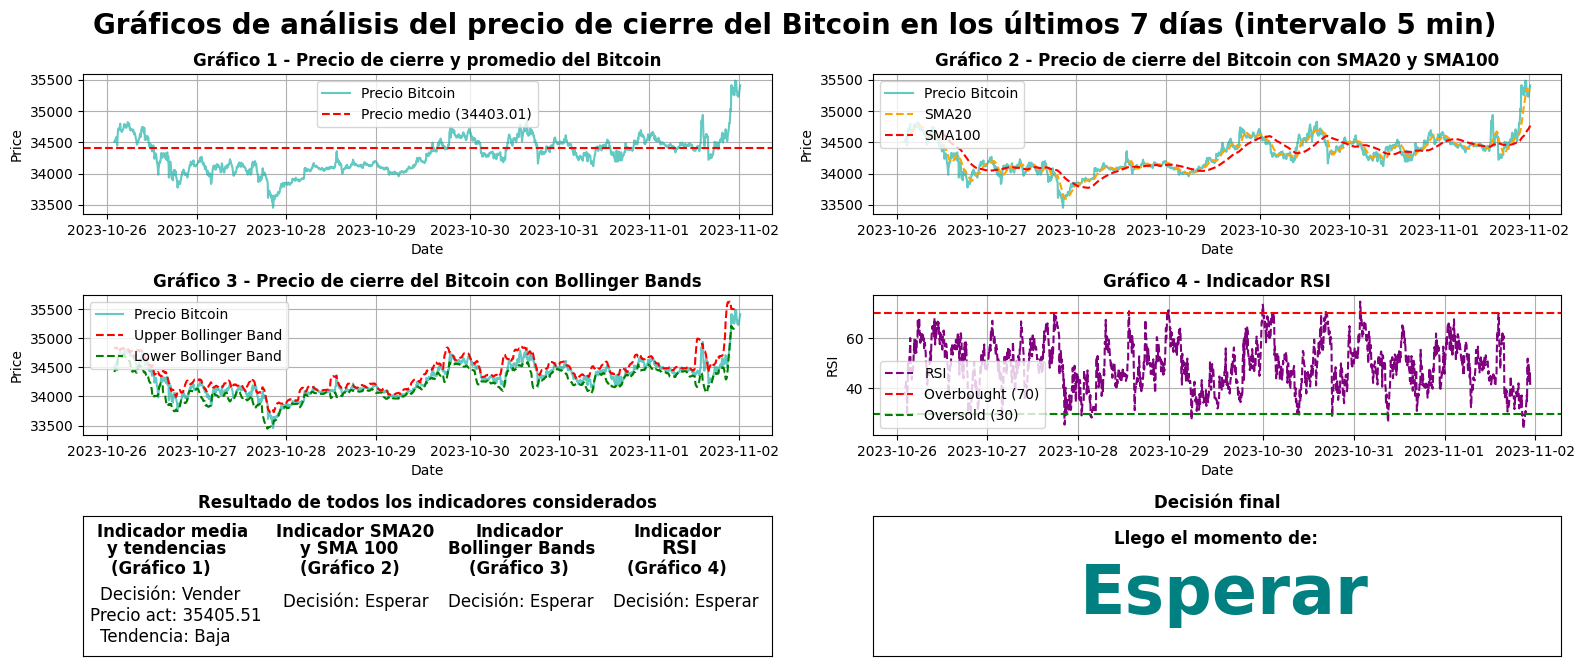

In [ ]:
# Automatización final! con actualización cada 5 minutos
while(True):
  clear_output(wait=True)
  importar_base_bitcoin('BTC-USD','7d','5m')
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  tomar_decisiones_msa()
  tomar_decisiones_bands()
  tomar_decisiones_rsi()
  tomar_decision_final()
  visualizacion()
  time.sleep(300)